In [4]:
import pandas as pd
import numpy as np 

from src.visualization.visualize import plot_decision_boundary
from src.data.helpers import list_to_model, model_to_list, rotate, get_moons_dataset
from src.model.models import MLP

import torch.nn.utils.prune as prune
import torch

from tqdm import tqdm
import matplotlib.pyplot as plt

from collections import defaultdict

In [5]:
def get_discard_map(data, angles, X, y, parameters = 33):
    discard_rate = np.zeros((parameters))
    discard_map = np.ones((parameters))

    for i in tqdm(range(len(data))):
        weights = (data[i])
        X_rotated = rotate(X, angles[i])
        X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

        for j in range(1, parameters):
            mask = abs(weights).argsort().argsort() < j
            masked_weights = weights.copy()
            masked_weights[mask] = 0
            masked_weights = torch.tensor(masked_weights, dtype=torch.float32)
            accuracy = get_accuracy(masked_weights, X_rotated, y)
            if(accuracy < 95):
                break
        mask = abs(weights).argsort().argsort() < j-1
        discard_rate += (discard_map * mask)
    
    return discard_rate

## Pruning small zoo

In [64]:
from src.model.models import DBModel

def get_accuracy(parameters, X, y):
    '''
    Get the accuracy of a Moons classifier on a moons dataset.
    '''
    model = DBModel(False)
    y_pred = model(parameters, X).squeeze().detach().round().numpy()
    correct = (y_pred == y).sum()
    accuracy = correct / len(y) * 100
    return accuracy

In [65]:
import torch
import numpy as np
from src.model.models import MLP
from src.data.helpers import get_moons_dataset, list_to_model, rotate
from src.visualization.visualize import plot_decision_boundary
from tqdm.notebook import tqdm
from collections import defaultdict


data = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data[:, -1]
data = data[:, 1:-1]


X, y = get_moons_dataset(n_samples=1000, noise=0.1)

In [66]:
discard_rate = get_discard_map(data, angles, X, y, parameters=33)

  0%|          | 0/80000 [00:00<?, ?it/s]

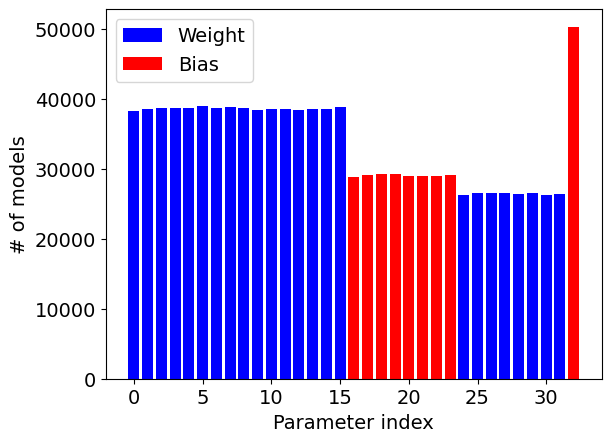

In [70]:
plt.rcParams.update({'font.size': 14})

handles = [
        Patch(facecolor="blue", label="Weight"),
        Patch(facecolor="red", label="Bias")
    ]

color = ["blue"]*16 + ["red"]*8 + ["blue"]*8 + ["red"]*1
plt.bar(range(33), discard_rate, color=color)
plt.xlabel("Parameter index")
plt.ylabel("# of models")

plt.legend(handles=handles)
plt.savefig("../reports/pruning-graph-small.pdf", bbox_inches='tight')
plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

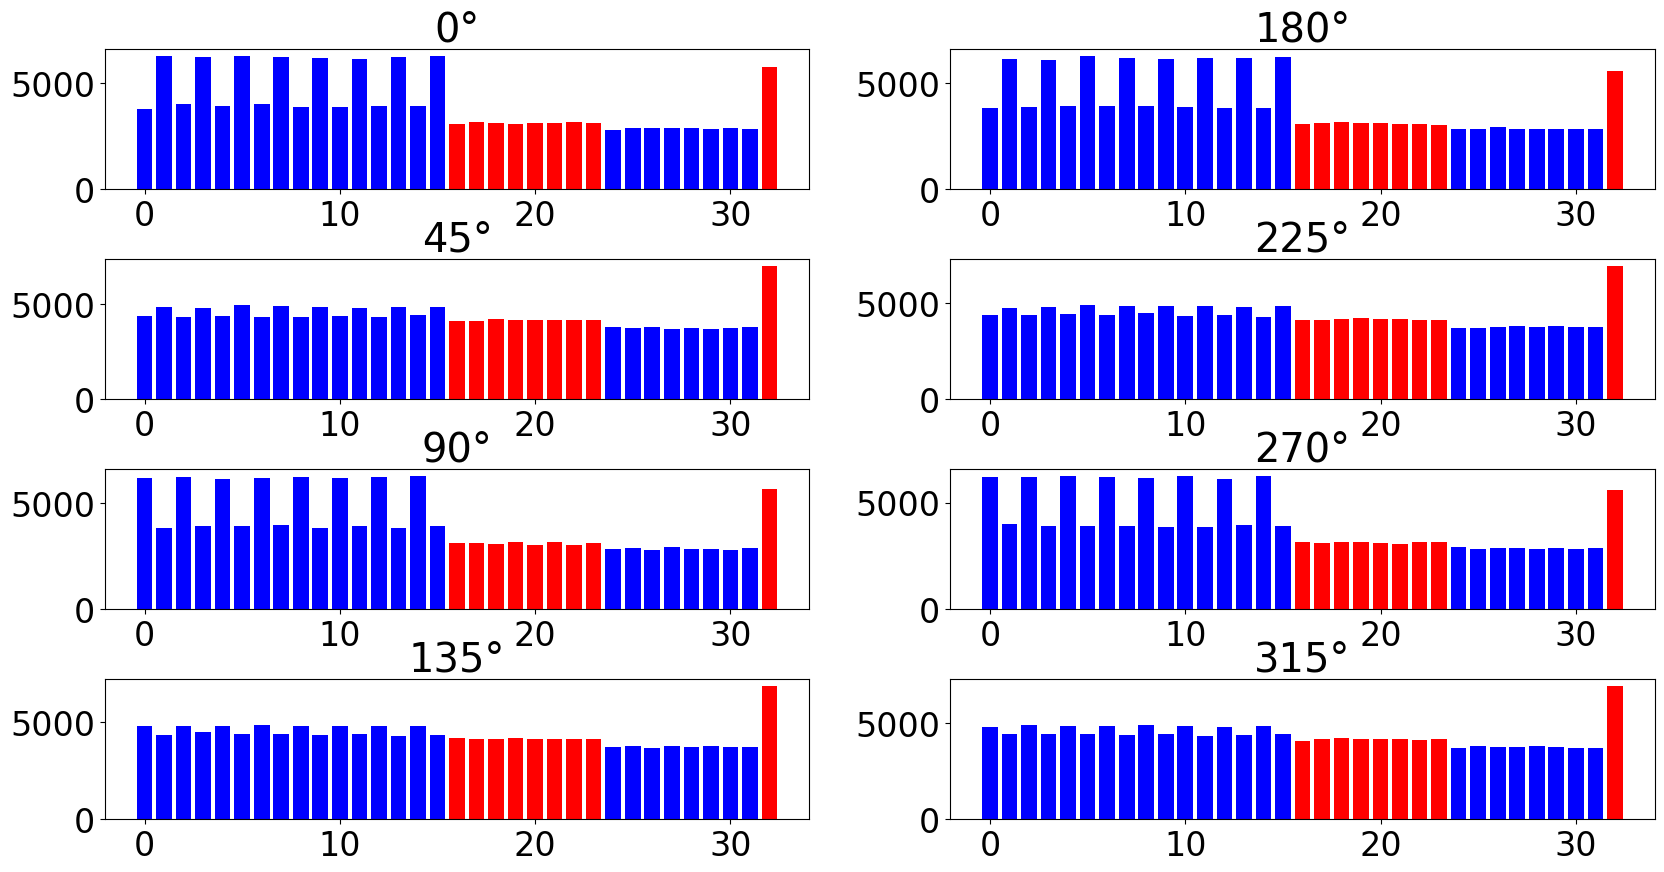

In [ ]:
# Per angle pruning
plt.rcParams.update({'font.size': 24})
angles = list(range(0,360,45))
dataset = pd.read_csv('../data/eight_angles_small.csv')
X, y = get_moons_dataset(n_samples=1000, noise=0.1)

handles = [
    Patch(facecolor="blue", label="Weight"),
    Patch(facecolor="red", label="Bias")
]
color = ["blue"]*16 + ["red"]*8 + ["blue"]*8 + ["red"]*1

fig, ax = plt.subplots(4, 2, figsize=(20,10))
plt.subplots_adjust(hspace = 0.5)
for angle in tqdm(angles):
    data = dataset[dataset["angle"] == angle]
    angles = data["angle"].to_numpy()
    data = data.drop(columns=["model_name", "angle"]).to_numpy()
    discard_rate = get_discard_map(data, angles, X, y)

    ax[(angle%180)//45][angle//180].bar(range(len(discard_rate)), discard_rate, color=color)
    ax[(angle%180)//45][angle//180].set_title(f"{angle}°")

plt.savefig("../reports/pruning-graphs-per-angle-small.pdf")
plt.show()

In [62]:
data = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data[:, -1]
data = data[:, 1:-1]


discard_rate = np.zeros((33))
discard_map = np.ones((33))
final_maps = []
discarded_counter = defaultdict(int)
X,y = get_moons_dataset()
for i in tqdm(range(80000)):
    weights = data[i]
    X_rotated = rotate(X, angles[i])
    X_rotated = torch.tensor(X_rotated, dtype=torch.float32)
    for j in range(1, 33):
        mask = abs(weights).argsort().argsort() < j
        masked_weights = weights.copy()
        masked_weights[mask] = 0
        masked_weights = torch.tensor(masked_weights, dtype=torch.float32)
        accuracy = get_accuracy(masked_weights, X_rotated, y)
        if(accuracy < 95):
            break
    mask = abs(weights).argsort().argsort() < j-1
    discarded_counter[j-1] += 1
    final_maps.append(mask)
    discard_rate += (discard_map * mask)

  0%|          | 0/80000 [00:00<?, ?it/s]

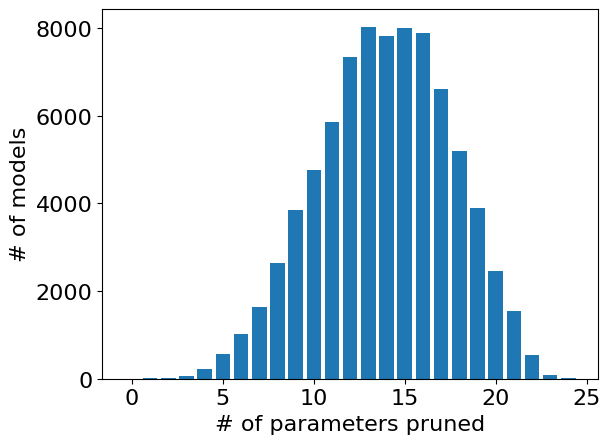

In [63]:
plt.rcParams.update({'font.size': 16})
x = list(discarded_counter.keys())
y = list(discarded_counter.values())
plt.bar(x, y)
# plt.title("Parameters discarded (acc > 95%)")
plt.xlabel("# of parameters pruned")
plt.ylabel("# of models")
plt.savefig("../reports/pruning-histogram-small.pdf", bbox_inches='tight')
plt.show()

In [56]:
# We can remove 24 parameters and still have 95% accuracy

weights = data[10941]
X_rotated = rotate(X, angles[10941])

mask = abs(weights).argsort().argsort() < 24
masked_weights = weights.copy()
accuracy = get_accuracy(masked_weights, X_rotated, y)
print(accuracy)
plot_decision_boundary(masked_weights, X_rotated, y)
masked_weights[mask] = 0
print(accuracy)
plot_decision_boundary(masked_weights, X_rotated, y)


TypeError: matmul(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

## Pruning medium zoo

In [47]:
from src.model.models import DBModelMedium

def get_accuracy(parameters, X, y):
    '''
    Get the accuracy of a Moons classifier on a moons dataset.
    '''
    model = DBModelMedium(False)
    y_pred = model(parameters, X).squeeze().detach().round().numpy()
    correct = (y_pred == y).sum()
    accuracy = correct / len(y) * 100
    return accuracy

In [6]:
import torch
import numpy as np
from src.model.models import MLP
from src.data.helpers import get_moons_dataset, list_to_model, rotate
from src.visualization.visualize import plot_decision_boundary
from tqdm.notebook import tqdm
from collections import defaultdict


data = np.genfromtxt('../data/eight_angles_medium.csv', delimiter=',', skip_header=1)
angles = data[:, -1]
data = data[:, 1:-1]


X, y = get_moons_dataset(n_samples=1000, noise=0.1)

In [7]:
discard_rate_medium = get_discard_map(data, angles, X, y, parameters=151)

  0%|          | 0/80000 [00:00<?, ?it/s]

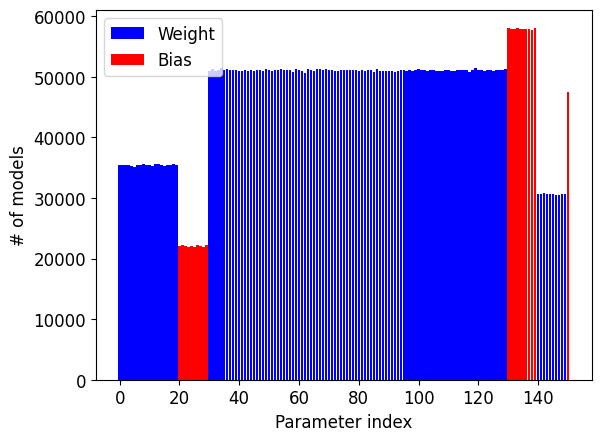

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

plt.rcParams.update({'font.size': 12})
handles = [
        Patch(facecolor="blue", label="Weight"),
        Patch(facecolor="red", label="Bias")
    ]

preserve_rate = discard_rate_medium
# preserve_rate = 80000 - discard_rate
color = ["blue"]*16 + ["red"]*8 + ["blue"]*8 + ["red"]*1
color = ["blue"]*20 + ["red"]*10 + ["blue"]*100 + ["red"]*10 + ["blue"]*10 + ["red"]*1
plt.bar(range(151), preserve_rate, color=color)
plt.xlabel("Parameter index")
plt.ylabel("# of models")

plt.legend(handles=handles)
plt.savefig("../reports/discard_graph_medium.pdf")
plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

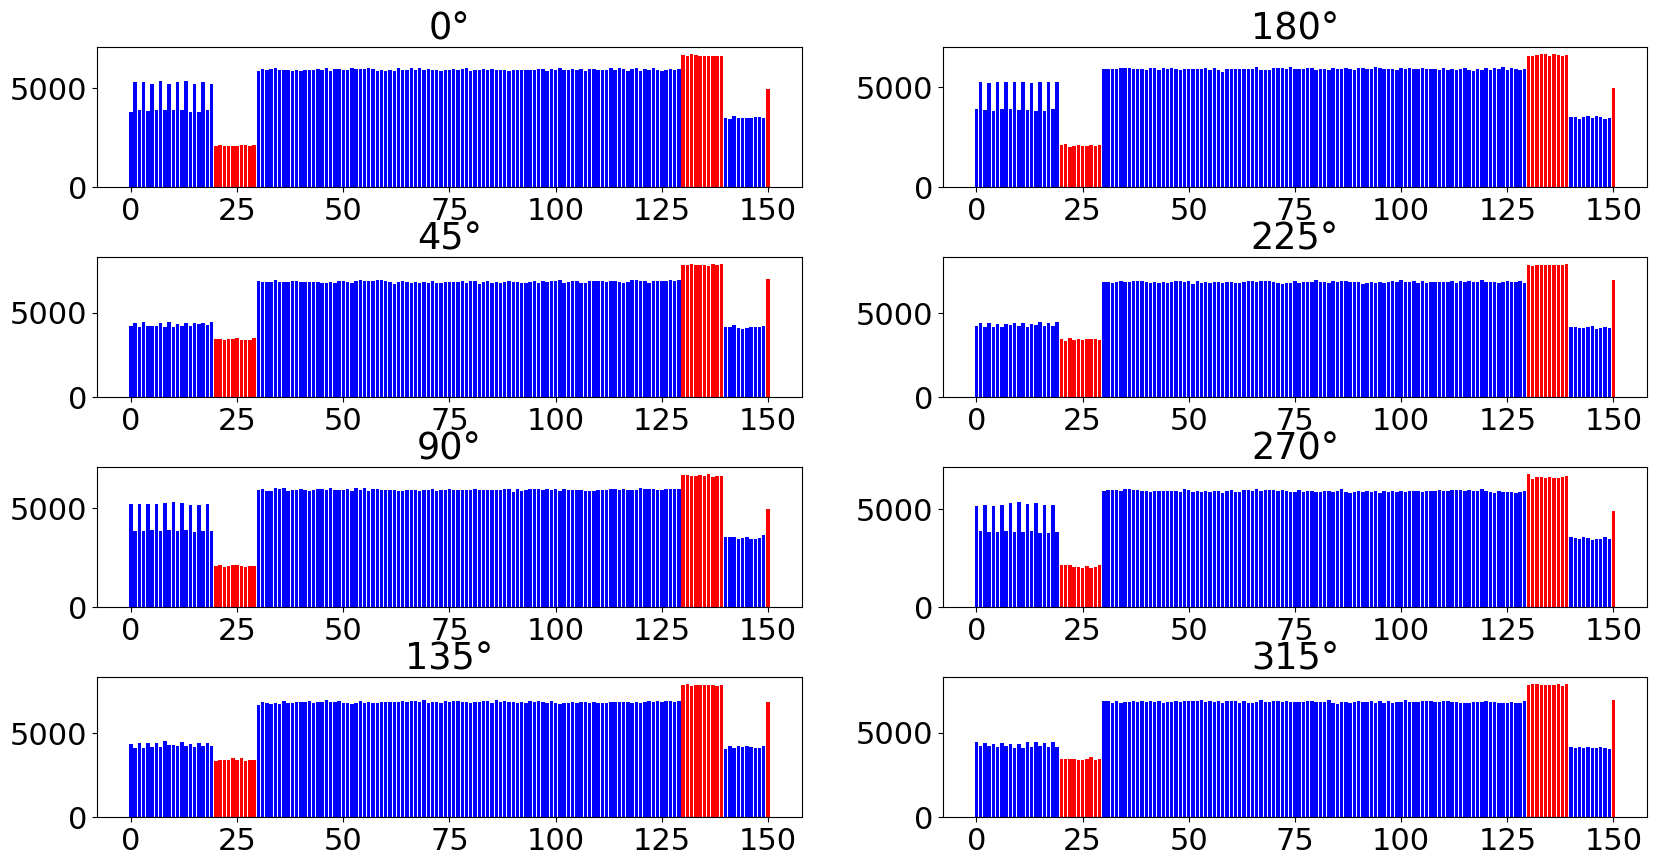

In [33]:
# Per angle pruning

angles = list(range(0,360,45))
dataset = pd.read_csv('../data/eight_angles_medium.csv')
X, y = get_moons_dataset(n_samples=1000, noise=0.1)
plt.rcParams.update({'font.size': 22})
handles = [
    Patch(facecolor="blue", label="Weight"),
    Patch(facecolor="red", label="Bias")
]
color = ["blue"]*20 + ["red"]*10 + ["blue"]*100 + ["red"]*10 + ["blue"]*10 + ["red"]*1

fig, ax = plt.subplots(4, 2, figsize=(20,10))
plt.subplots_adjust(hspace = 0.5)
for angle in tqdm(angles):
    data = dataset[dataset["angle"] == angle]
    angles = data["angle"].to_numpy()
    data = data.drop(columns=["model_name", "angle"]).to_numpy()
    discard_rate = get_discard_map(data, angles, X, y, parameters=151)

    ax[(angle%180)//45][angle//180].bar(range(len(discard_rate)), discard_rate, color=color)
    ax[(angle%180)//45][angle//180].set_title(f"{angle}°")

plt.savefig("../reports/pruning_graphs_per_angle_medium.pdf")
plt.show()

In [49]:
data = np.genfromtxt('../data/eight_angles_medium.csv', delimiter=',', skip_header=1)
angles = data[:, -1]
data = data[:, 1:-1]


discard_rate = np.zeros((151))
discard_map = np.ones((151))
final_maps = []
discarded_counter = defaultdict(int)
X,y = get_moons_dataset()

for i in tqdm(range(80000)):
    weights = data[i]
    X_rotated = rotate(X, angles[i])
    X_rotated = torch.tensor(X_rotated, dtype=torch.float32)
    for j in range(1, 151):
        mask = abs(weights).argsort().argsort() < j
        masked_weights = weights.copy()
        masked_weights[mask] = 0
        masked_weights = torch.tensor(masked_weights, dtype=torch.float32)
        accuracy = get_accuracy(masked_weights, X_rotated, y)
        if(accuracy < 95):
            break
    mask = abs(weights).argsort().argsort() < j-1
    discarded_counter[j-1] += 1
    final_maps.append(mask)
    discard_rate += (discard_map * mask)

  0%|          | 0/80000 [00:00<?, ?it/s]

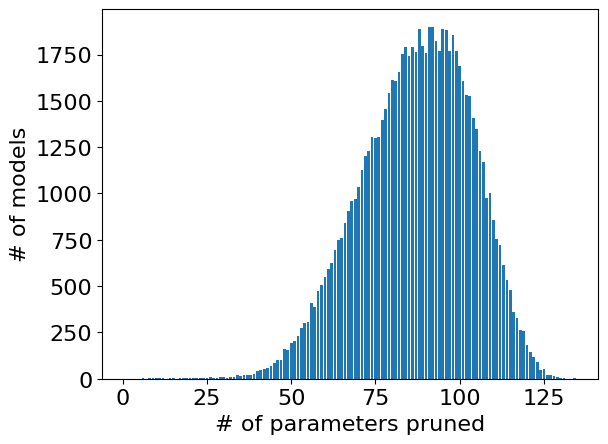

In [52]:
plt.rcParams.update({'font.size': 16})


x = list(discarded_counter.keys())
y = list(discarded_counter.values())
plt.bar(x, y)
# plt.title("Parameters discarded (acc > 95%)")
plt.xlabel("# of parameters pruned")
plt.ylabel("# of models")
plt.savefig("../reports/pruning-histogram-medium.pdf", bbox_inches='tight')
plt.show()

## Pruning big zoo

In [53]:
from src.model.models import DBModelBig

def get_accuracy(parameters, X, y):
    '''
    Get the accuracy of a Moons classifier on a moons dataset.
    '''
    model = DBModelBig(False)
    y_pred = model(parameters, X).squeeze().detach().round().numpy()
    correct = (y_pred == y).sum()
    accuracy = correct / len(y) * 100
    return accuracy

In [35]:
import torch
import numpy as np
from src.model.models import MLP
from src.data.helpers import get_moons_dataset, list_to_model, rotate
from src.visualization.visualize import plot_decision_boundary
from tqdm.notebook import tqdm
from collections import defaultdict


data = np.genfromtxt('../data/eight_angles_big.csv', delimiter=',', skip_header=1)
angles = data[:, -1]
data = data[:, 1:-1]


X, y = get_moons_dataset(n_samples=1000, noise=0.1)

In [36]:
discard_rate_big = get_discard_map(data, angles, X, y, parameters=261)

  0%|          | 0/80000 [00:00<?, ?it/s]

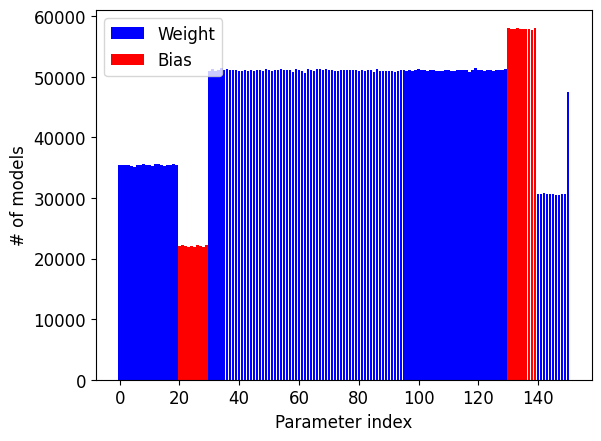

In [37]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

plt.rcParams.update({'font.size': 12})
handles = [
        Patch(facecolor="blue", label="Weight"),
        Patch(facecolor="red", label="Bias")
    ]

preserve_rate = discard_rate_medium
# preserve_rate = 80000 - discard_rate
color = ["blue"]*16 + ["red"]*8 + ["blue"]*8 + ["red"]*1
color = ["blue"]*20 + ["red"]*10 + ["blue"]*100 + ["red"]*10 + ["blue"]*100 + ["red"]*10 + ["blue"]*10 + ["red"]*1
plt.bar(range(151), preserve_rate, color=color)
plt.xlabel("Parameter index")
plt.ylabel("# of models")

plt.legend(handles=handles)
plt.savefig("../reports/discard_graph_big.pdf")
plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

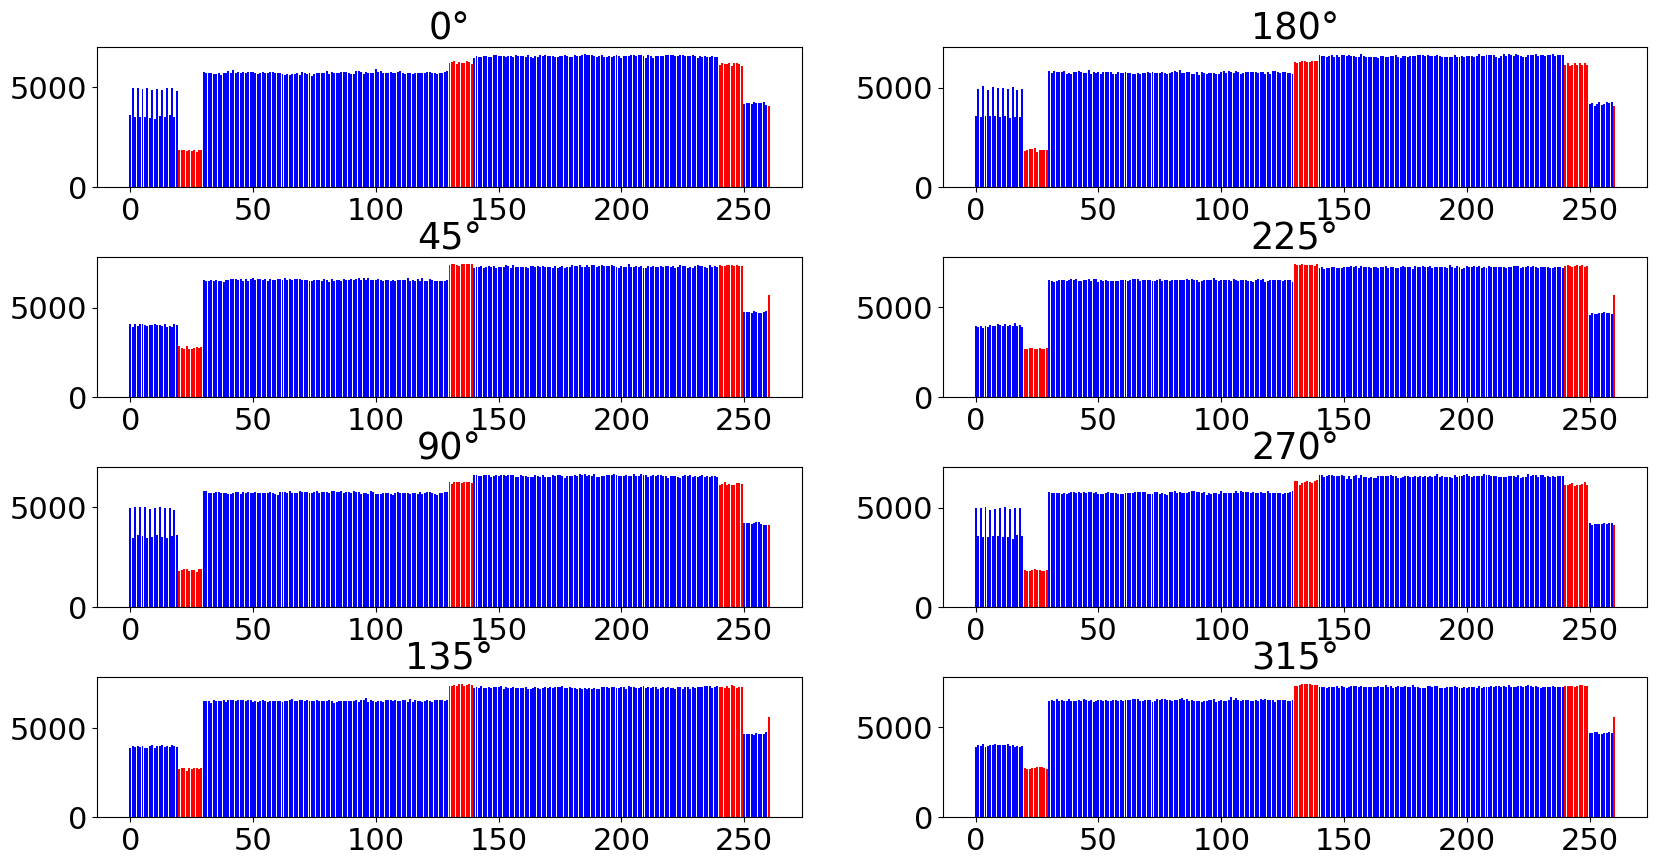

In [39]:
# Per angle pruning

angles = list(range(0,360,45))
dataset = pd.read_csv('../data/eight_angles_big.csv')
X, y = get_moons_dataset(n_samples=1000, noise=0.1)
plt.rcParams.update({'font.size': 22})
handles = [
    Patch(facecolor="blue", label="Weight"),
    Patch(facecolor="red", label="Bias")
]
color = ["blue"]*20 + ["red"]*10 + ["blue"]*100 + ["red"]*10 + ["blue"]*100 + ["red"]*10 + ["blue"]*10 + ["red"]*1


fig, ax = plt.subplots(4, 2, figsize=(20,10))
plt.subplots_adjust(hspace = 0.5)
for angle in tqdm(angles):
    data = dataset[dataset["angle"] == angle]
    angles = data["angle"].to_numpy()
    data = data.drop(columns=["model_name", "angle"]).to_numpy()
    discard_rate = get_discard_map(data, angles, X, y, parameters=261)

    ax[(angle%180)//45][angle//180].bar(range(len(discard_rate)), discard_rate, color=color)
    ax[(angle%180)//45][angle//180].set_title(f"{angle}°")

plt.savefig("../reports/pruning_graphs_per_angle_big.pdf")
plt.show()

In [55]:
data = np.genfromtxt('../data/eight_angles_big.csv', delimiter=',', skip_header=1)
angles = data[:, -1]
data = data[:, 1:-1]

plt.rcParams.update({'font.size': 24})

discard_rate = np.zeros((261))
discard_map = np.ones((261))
final_maps = []
discarded_counter = defaultdict(int)
X,y = get_moons_dataset()
for i in tqdm(range(80000)):
    weights = data[i]
    X_rotated = rotate(X, angles[i])
    X_rotated = torch.tensor(X_rotated, dtype=torch.float32)
    for j in range(1, 261):
        mask = abs(weights).argsort().argsort() < j
        masked_weights = weights.copy()
        masked_weights[mask] = 0
        masked_weights = torch.tensor(masked_weights, dtype=torch.float32)
        accuracy = get_accuracy(masked_weights, X_rotated, y)
        if(accuracy < 95):
            break
    mask = abs(weights).argsort().argsort() < j-1
    discarded_counter[j-1] += 1
    final_maps.append(mask)
    discard_rate += (discard_map * mask)

  0%|          | 0/80000 [00:00<?, ?it/s]

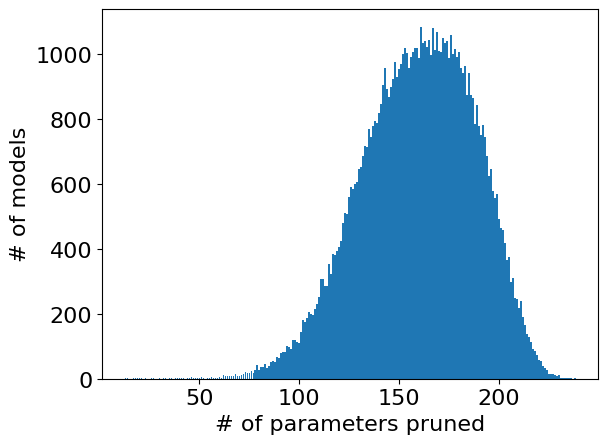

In [58]:
plt.rcParams.update({'font.size': 16})


x = list(discarded_counter.keys())
y = list(discarded_counter.values())
plt.bar(x, y)
# plt.title("Parameters discarded (acc > 95%)")
plt.xlabel("# of parameters pruned")
plt.ylabel("# of models")
plt.savefig("../reports/pruning-histogram-big.pdf", bbox_inches='tight')
plt.show()